In [1]:
%config Completer.use_jedi = False

In [2]:
import os
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import scipy
from scipy.stats import multivariate_normal

In [3]:
from vae_model import VAE as _VAE

In [4]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data, test_data = data['train'] > 255/2, data['test'] > 255/2
    train_labels, test_labels = data['train_labels'], data['test_labels']
    return train_data, test_data, train_labels, test_labels


def show_samples(samples, title=None, nrow=10):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure(figsize=(10,10))
    if title is not None:
        plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def visualize_data(data, title):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)
    

def visualize_batch(batch, nrow=10):
    show_samples(batch[...,None], nrow=nrow)


def plot_training_curves(train_losses, test_losses):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [5]:
train_data, test_data, train_labels, test_labels = load_pickle('mnist.pkl')

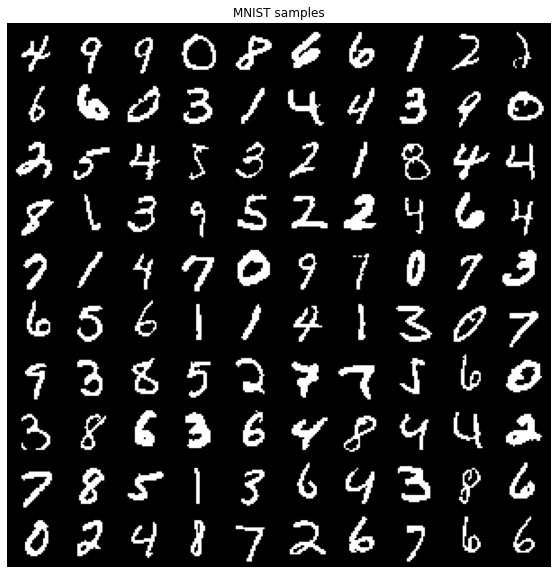

In [6]:
visualize_data(train_data, 'MNIST samples')

In [7]:
i = 0
x = train_data[0]

In [8]:
x.max(), x.min(), x.shape

(True, False, (28, 28, 1))

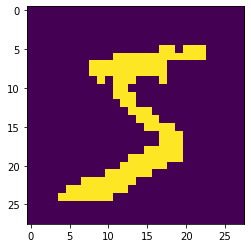

In [9]:
plt.imshow(x)

In [10]:
def train_epoch(model, train_loader, optimizer, epoch, loss_key='total'):
    model.train()
    stats = defaultdict(list)
    for x in train_loader:
        #x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())
    return stats


def eval_model(model, data_loader):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            #x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(model, train_loader, test_loader, epochs, lr, loss_key='total'):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, epoch, loss_key)
        test_loss = eval_model(model, test_loader)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)


def solve_task(train_data, test_data, model, batch_size, epochs, lr):
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
    )
    
    for key, value in test_losses.items():
        print('{}: {:.4f}'.format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)

In [38]:
ENC_HIDDEN_SIZES = [128, 64, 32]
DEC_HIDDEN_SIZES = [32, 64, 128]
BATCH_SIZE = 128
EPOCHS = 10
LR = 0.003

In [39]:
model = VAE(28*28, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).float()

elbo_loss: 144.3570
recon_loss: 138.0001
kl_loss: 6.3569


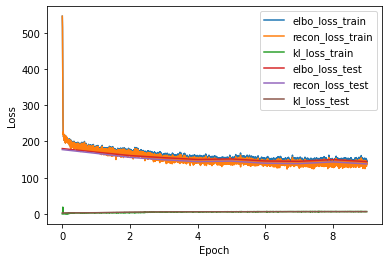

In [40]:
train_loader = DataLoader(train_data[...,0].astype(np.float32), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data[...,0].astype(np.float32), batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))

plot_training_curves(train_losses, test_losses)

In [41]:
model_vae = model

In [ ]:
# look at the batch, and samples

In [ ]:
for batch in train_loader:
    break

In [ ]:
batch.shape

In [13]:
visualize_batch(batch)

NameError: name 'batch' is not defined

In [14]:
samples = model.sample(100)

NameError: name 'model' is not defined

In [15]:
visualize_batch(samples>0.5)

NameError: name 'samples' is not defined

In [16]:
############

In [17]:
def get_batch_of_labels(label, batch_size, data_with_labels=(test_data, test_labels)):
    data, labels = data_with_labels
    idx = np.random.choice(np.argwhere(labels == label).flatten(), batch_size, replace=False)
    
    return data[idx][...,0]

In [18]:
batch = get_batch_of_labels(4, 20)

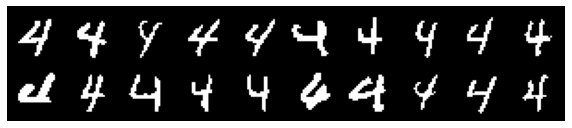

In [19]:
visualize_batch(batch)

In [20]:
# TODO: look at z for bathces of the same elements
# plot N(0,1)

In [21]:
def get_pdf(mu, sigma):
    x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mu, [[sigma[0], 0],[0, sigma[1]]])
    return rv.pdf(pos)

def get_pic(mu, sigma):
    res = get_pdf(mu, sigma)
    pic = res.T[::-1,:]
    
    return pic

def get_pics(mu_s, sigma_s):
    return np.array([get_pic(m, s) for m,s in zip(mu_s, sigma_s)])

In [22]:
prior = get_pic(np.array([0,0]), np.array([1,1]))

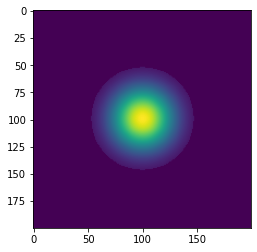

In [23]:
plt.imshow(prior*(prior > 0.01))

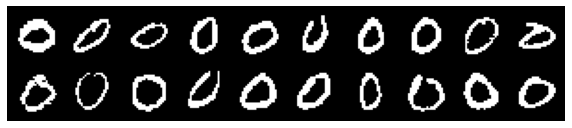

NameError: name 'model' is not defined

In [24]:
for i in range(10):
    batch = get_batch_of_labels(i, 20)
    visualize_batch(batch)

    latent_batch = model.get_latent(batch)
    latent_pics = get_pics(*latent_batch)
    visualize_batch(latent_pics)
    res = latent_pics.mean(axis=0)
    plt.imshow(res)

In [25]:
# TODO: look at samples from laten's grid

In [26]:
a = 3
step = 0.25

x, y = np.mgrid[-a:a:step, -a:a:step]
pos = np.dstack((x, y))
n_row = pos.shape[0]

pos = pos.reshape((np.product(pos.shape[:2]), 2))

samples = torch.sigmoid(model.decoder(torch.from_numpy(pos).float()))
samples = samples.detach().numpy().reshape((samples.shape[0], 28, 28))

NameError: name 'model' is not defined

In [27]:
visualize_batch(samples, n_row)

NameError: name 'samples' is not defined

## Seminar 7 starts here

In [28]:
# TODO: plot posteriors

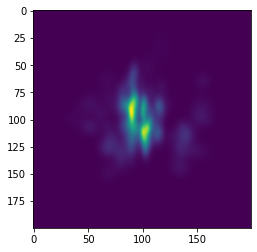

In [42]:
batch = np.vstack([get_batch_of_labels(i, 20) for i in range(10)])
#visualize_batch(batch)

latent_batch = model.get_latent(batch)
latent_pics = get_pics(*latent_batch)
#visualize_batch(latent_pics)
res = latent_pics.mean(axis=0)
plt.imshow(res)

In [30]:
import math
class VAE(_VAE):
    def __init__(self, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes):
        super().__init__(n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes)
    
    def log_pdf_normal(self, distr, samples):
        # distr - (bs, n_latent)
        # samples - (bs, K, n_latent)
        mu, sigma = distr

        batch_size = mu.shape[0]
        latent_dim = mu.shape[1]

        f1 = torch.sum(((samples -
                         mu.view([batch_size, 1, latent_dim]))**2) /
                       sigma.view([batch_size, 1, latent_dim])**2, dim=2)
        f2 = mu.shape[1] * (math.log(2) + math.log(math.pi))
        f3 = torch.sum(torch.log(sigma), dim=1).view(batch_size, 1)
        return -0.5 * (f1 + f2) - f3
    
    # -----
    
    def q_z(self, x):
        x = x.view(x.shape[0], -1)
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        
        return mu_z, log_std_z.exp()
    
    def p_z(self, num_samples):
        mu = torch.zeros([num_samples, self.n_latent])
        sigma = torch.ones([num_samples, self.n_latent])
        return mu, sigma    
        
    def sample_z(self, distr, num_samples):
        mu, sigma = distr
        
        batch_size = mu.shape[0]
        bias = mu.view([batch_size, 1, self.n_latent])

        epsilon = torch.randn([batch_size, num_samples, self.n_latent],
                              requires_grad=True)
        
        scale = sigma.view([batch_size, 1, self.n_latent])

        return bias + epsilon * scale
    
    def q_x(self, z):
        z_shape = z.shape
        return torch.sigmoid(self.decoder(z.view(-1, self.n_latent))).view(*z_shape[:2], -1)
    
    # -----
    def log_mean_exp(self, data):
        
        return torch.logsumexp(data, dim=-1) - \
            torch.log(torch.Tensor([data.shape[-1]]).to(data.device))
    
    def sample_z_IW(self, batch_x):
        batch_x = batch_x.view((batch_x.shape[0], -1))
        pri_distr = self.p_z(batch_x.shape[0])
        propos_distr = self.q_z(batch_x)

        z_latent = self.sample_z(propos_distr, self.K)

        x_distr = self.q_x(z_latent)

        log_likelihood_true_distr = self.log_likelihood(batch_x, x_distr, self.K)

        normal_log_pdf_prior = self.log_pdf_normal(pri_distr, z_latent)

        normal_log_pdf_propos = self.log_pdf_normal(propos_distr, z_latent)

        log_weight = log_likelihood_true_distr + \
            normal_log_pdf_prior - normal_log_pdf_propos

        weight = torch.softmax(log_weight, dim=1)

        cat = torch.distributions.Categorical(weight)

        indexes = cat.sample((1,))

        return z_latent[:, indexes, :][0]

In [43]:
import math
class IWAE(VAE):
    def __init__(self, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes, K):
        super().__init__(n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes)
        self.K = K
    
    def loss(self, batch_x):
        batch_x = batch_x.view((batch_x.shape[0], -1))
        propos_distr = self.q_z(batch_x)
        pri_distr = self.p_z(batch_x.shape[0])

        z_latent = self.sample_z(propos_distr, num_samples=self.K)
        x_distr = self.q_x(z_latent)

        log_likelihood_true_distr = self.log_likelihood(batch_x, x_distr, K=self.K)
        normal_log_pdf_prior = self.log_pdf_normal(pri_distr, z_latent)
        normal_log_pdf_propos = self.log_pdf_normal(propos_distr, z_latent)

        exponent = log_likelihood_true_distr + \
            normal_log_pdf_prior - normal_log_pdf_propos

        expectation = torch.mean(self.log_mean_exp(exponent), dim=0)

        l = -1 * torch.mean(expectation, dim=0)
        
        return {
            'elbo_loss': l,
            'recon_loss': torch.Tensor([0])[0],
            'kl_loss': torch.Tensor([0])[0]
        }

In [44]:
#######

In [45]:
model = IWAE(28*28, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES, 5).float()

elbo_loss: 135.9438
recon_loss: 0.0000
kl_loss: 0.0000


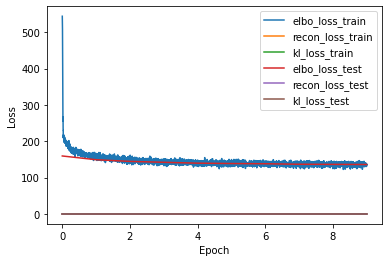

In [46]:
train_loader = DataLoader(train_data[...,0].astype(np.float32), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data[...,0].astype(np.float32), batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))

plot_training_curves(train_losses, test_losses)

In [47]:
model_iwae = model

In [48]:
batch = np.vstack([get_batch_of_labels(i, 20) for i in range(10)])
#visualize_batch(batch)

IWAE


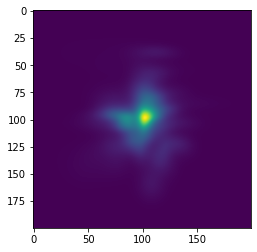

In [53]:
print('IWAE')
latent_batch = model_iwae.get_latent(batch)
latent_pics = get_pics(*latent_batch)
#visualize_batch(latent_pics)
res = latent_pics.mean(axis=0)
plt.imshow(res)

VAE


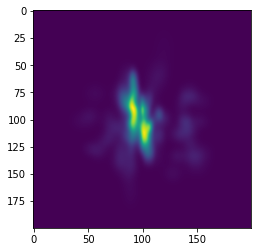

In [54]:
print('VAE')
latent_batch = model_vae.get_latent(batch)
latent_pics = get_pics(*latent_batch)
#visualize_batch(latent_pics)
res = latent_pics.mean(axis=0)
plt.imshow(res)

In [58]:
a = 3
step = 0.25

x, y = np.mgrid[-a:a:step, -a:a:step]
pos = np.dstack((x, y))
n_row = pos.shape[0]

pos = pos.reshape((np.product(pos.shape[:2]), 2))

samples = torch.sigmoid(model_iwae.decoder(torch.from_numpy(pos).float()))
samples = samples.detach().numpy().reshape((samples.shape[0], 28, 28))

In [57]:
a = 3
step = 0.25

x, y = np.mgrid[-a:a:step, -a:a:step]
pos = np.dstack((x, y))
n_row = pos.shape[0]

pos = pos.reshape((np.product(pos.shape[:2]), 2))

samples = torch.sigmoid(model_vae.decoder(torch.from_numpy(pos).float()))
samples = samples.detach().numpy().reshape((samples.shape[0], 28, 28))

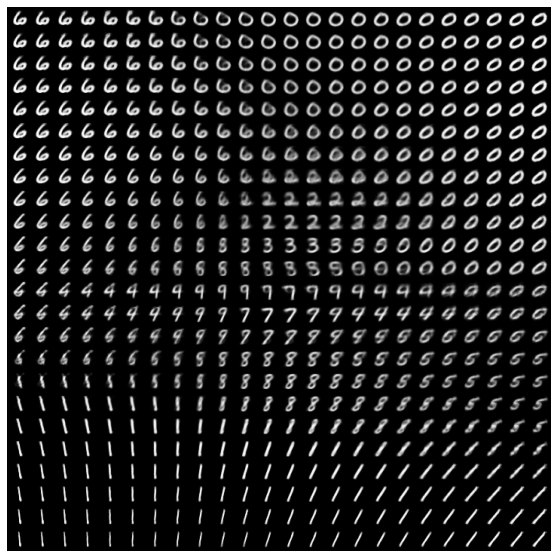

In [56]:
# VAE
visualize_batch(samples, n_row)

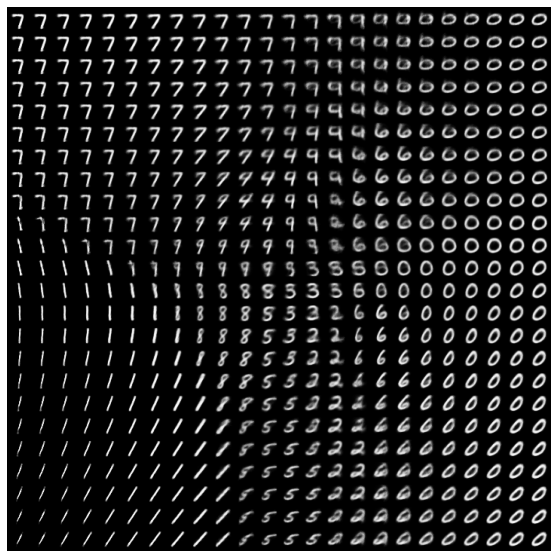

In [59]:
# IWAE
visualize_batch(samples, n_row)

In [ ]:
####

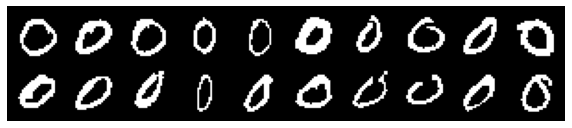

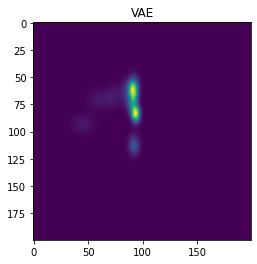

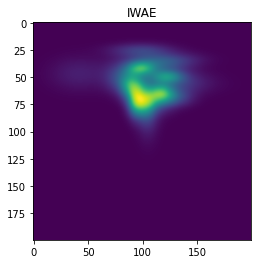

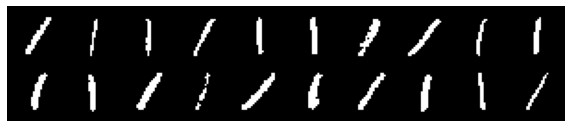

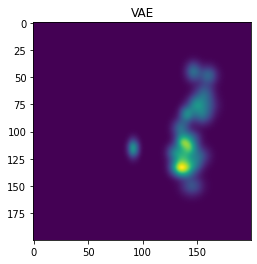

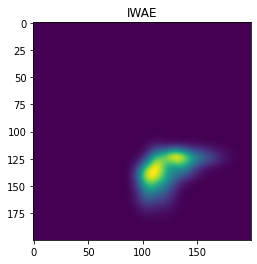

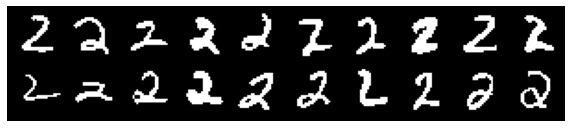

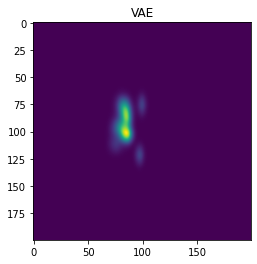

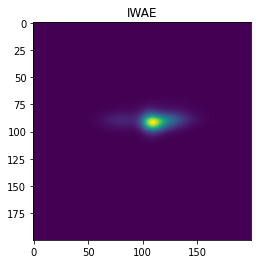

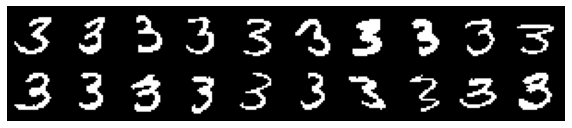

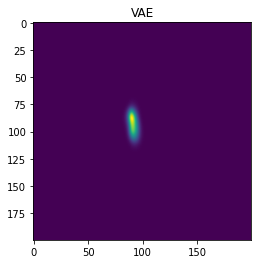

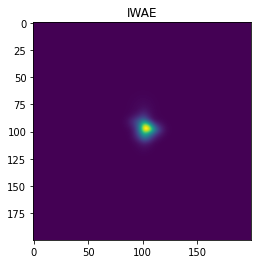

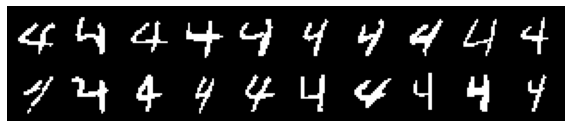

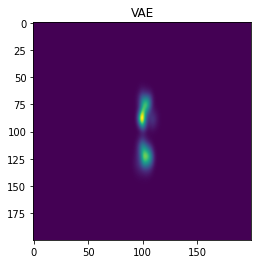

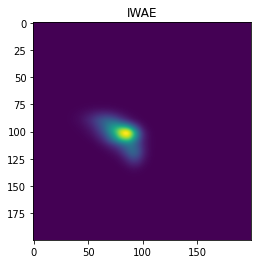

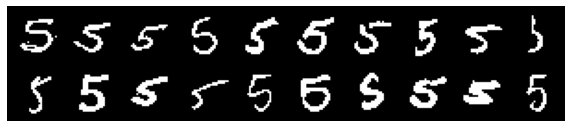

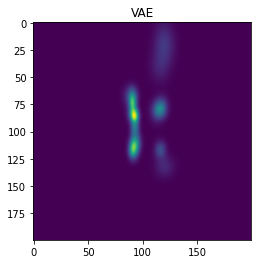

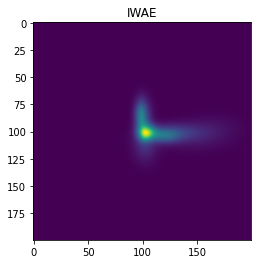

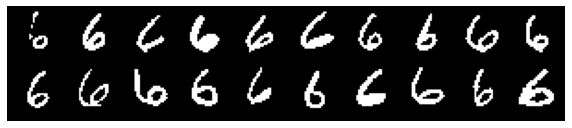

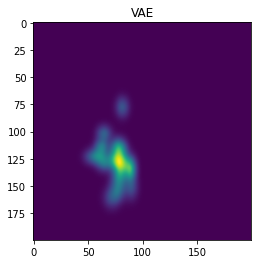

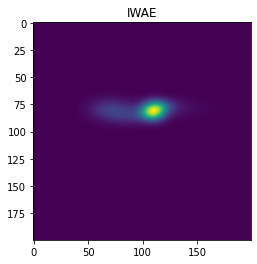

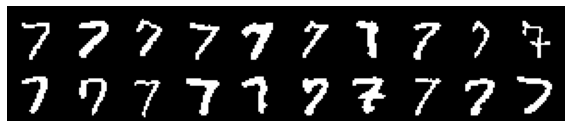

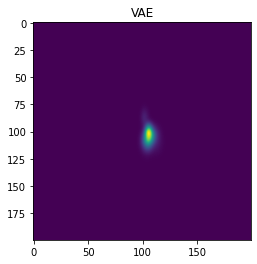

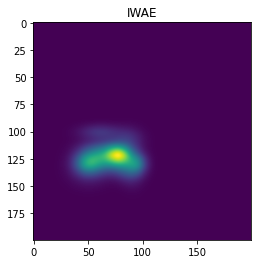

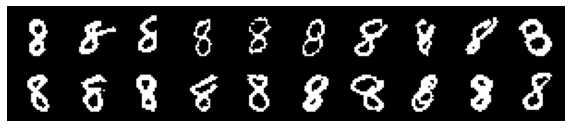

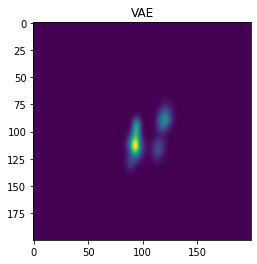

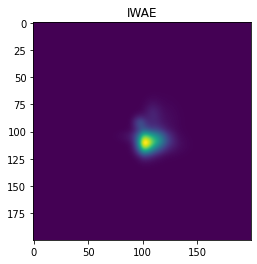

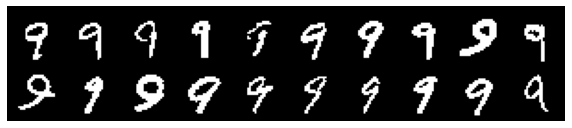

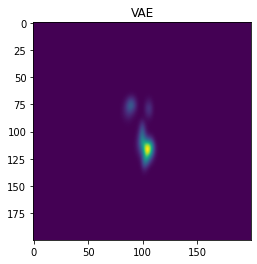

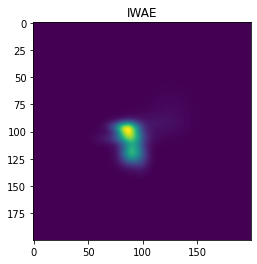

In [60]:
for i in range(10):
    batch = get_batch_of_labels(i, 20)
    visualize_batch(batch)

    latent_batch = model_vae.get_latent(batch)
    latent_pics = get_pics(*latent_batch)
    #visualize_batch(latent_pics)
    res = latent_pics.mean(axis=0)
    plt.title('VAE')
    plt.imshow(res)
    plt.show()
    
    latent_batch = model_iwae.get_latent(batch)
    latent_pics = get_pics(*latent_batch)
    #visualize_batch(latent_pics)
    res = latent_pics.mean(axis=0)
    plt.title('IWAE')
    plt.imshow(res)
    plt.show()

In [ ]:
######

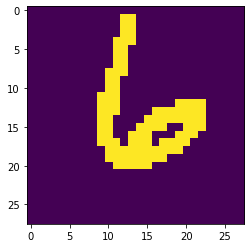

In [79]:
i = 6
k = 5
batch = get_batch_of_labels(i, 1)
plt.imshow(batch[0])

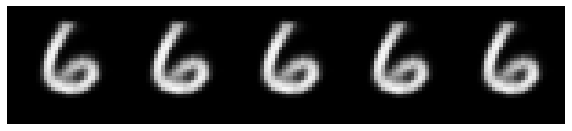

In [80]:
# VAE
with torch.no_grad():
    propos_distr = model_vae.q_z(torch.from_numpy(batch).view(1,-1).float())
    z_latent = model_vae.sample_z(propos_distr, num_samples=k)
    x_distr = model_vae.q_x(z_latent).view(k,28,28)

    visualize_batch(x_distr.detach())

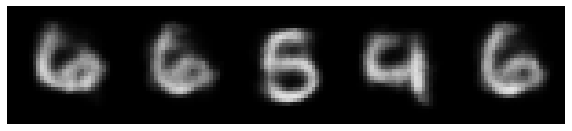

In [81]:
# IWAE
with torch.no_grad():
    propos_distr = model_iwae.q_z(torch.from_numpy(batch).view(1,-1).float())
    z_latent = model_iwae.sample_z(propos_distr, num_samples=k)
    x_distr = model_iwae.q_x(z_latent).view(k,28,28)

    visualize_batch(x_distr.detach())

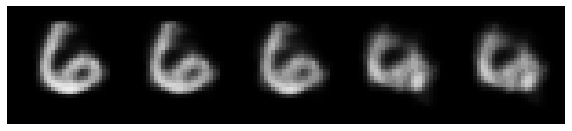

In [82]:
# IWAE + q_EW
with torch.no_grad():
    z_latent = [model_iwae.sample_z_IW(torch.from_numpy(batch).view(1,-1).float()) for i in range(k)]
    z_latent = torch.stack(z_latent)[:,0,...]
    x_distr = model_iwae.q_x(z_latent).view(k,28,28)

    visualize_batch(x_distr.detach())

In [ ]:
batch_x = torch.from_numpy(batch).view(1,-1).float()

In [ ]:
#####